In [702]:
#IMPORT CONSTANTS

import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
import copy

npzfile = {}

for i in ["rgb", "depth", "ir"]:
    type_dict = {}
    for j in ["_14", "_cal6", "_empty6"]:
        type_dict[j] = np.load("test"+j+"_"+i+"_array.npz")
    npzfile[i]=type_dict
    
im_array = {}

reference = {"ori": "_14",
             "cal": "_cal6",
             "emp": "_empty6"}

for i in ["rgb", "depth", "ir"]:
    type_dict = {}
    for j in ["ori", "cal", "emp"]:
        type_dict[j] = np.rot90(npzfile[i][reference[j]][i+"_image"],0)
        #type_dict[j] = np.fliplr(type_dict[j])
    im_array[i]=type_dict


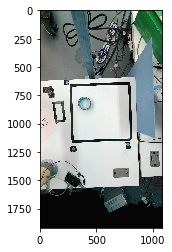

In [703]:
plt.imshow(im_array["rgb"]["ori"])

In [704]:
ir_img = copy.copy(im_array["ir"]["emp"])
ir_img /= ir_img.max()
ir_img = np.sqrt(ir_img)

19
All Calibration points found
Quit
[[[ 140.5         360.5           4.74341631]
  [ 123.5         156.5           4.74341631]
  [ 306.5         347.5           4.74341631]]]
[[ 123.5         156.5           4.74341631]
 [ 306.5         347.5           4.74341631]
 [ 140.5         360.5           4.74341631]]
[[ 123.5         156.5           4.74341631]
 [ 140.5         360.5           4.74341631]
 [ 306.5         347.5           4.74341631]]


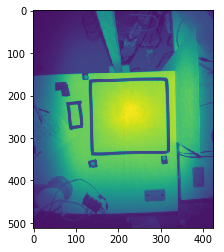

In [705]:
### FIND THE CIRCLES TO CROP FROM THE IR IMAGE

param = {'thresh': [65,100],
        'radius': [4, 9]}
show=True

blurred_img = cv2.medianBlur(ir_img*256, 3)
#gimg = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(blurred_img)
circles = None
counter = 0

while counter < 59 :
    #print (counter)
    circles = cv2.HoughCircles(blurred_img.astype("uint8"), cv2.HOUGH_GRADIENT, 1, 20,
                                   param1=param['thresh'][1],
                                   param2=param['thresh'][0]-counter,
                                   minRadius = param['radius'][0],
                                   maxRadius = param['radius'][1])

    if circles is not None and len(circles[0])>2:
        print param['thresh'][0]-counter
        print ('All Calibration points found')
        break

    counter = counter + 1

if circles is None:
    print ('No circles Detected, try changing param values')
cimg = cv2.cvtColor(ir_img,cv2.COLOR_GRAY2BGR)
#cimg = copy.copy(ir_img)
for i in circles[0,:]:
        # draw the outer circle
    cv2.circle(cimg,(int(i[0]),int(i[1])),int(i[2]),(0,0,255),1)
        # draw the center of the ci~rcle
    cv2.circle(cimg,(int(i[0]),int(i[1])),2,(0,0,255),1)

if show==True:
    cv2.imshow("Calibration Points Identified", cimg)
    cv2.imwrite("calibrated_image.jpg", cimg)
    if cv2.waitKey():# & 0xFF == ord('q'):
        print ("Quit")
    cv2.destroyAllWindows()
print circles

circles_sorted_depth = np.zeros(shape=np.shape(circles))
# Sort so that circle points ordered clockwise from top left
circles_sorted_depth[0] = circles[0][np.argsort(circles[0][:,1])]
print (circles_sorted_depth[0])
circles_sorted_depth[0][1:] = circles_sorted_depth[0][1:][np.argsort(circles_sorted_depth[0][1:][:,0])]
#circles_sorted[0][2:] = circles_sorted[0][2:][np.argsort(circles_sorted[0][2:][:,1])]
print (circles_sorted_depth[0])

crop_points_depth = [circles_sorted_depth[0][0][1], circles_sorted_depth[0][1][1], 
                       circles_sorted_depth[0][0][0], circles_sorted_depth[0][2][0]]

In [706]:
depth_img = copy.copy(im_array['depth']['ori'])
depth_emp_img = copy.copy(im_array['depth']['emp'])
depth_cal_img = copy.copy(im_array['depth']['cal'])
crop_points_depth = [int(i) for i in crop_points_depth]

print np.shape(depth_img)

depth_img = depth_img[crop_points_depth[0]:crop_points_depth[1], crop_points_depth[2]:crop_points_depth[3]]
depth_emp_img = depth_emp_img[crop_points_depth[0]:crop_points_depth[1], crop_points_depth[2]:crop_points_depth[3]]
depth_cal_img = depth_cal_img[crop_points_depth[0]:crop_points_depth[1], crop_points_depth[2]:crop_points_depth[3]]
print np.shape(depth_img)

(512, 424)
(204, 183)


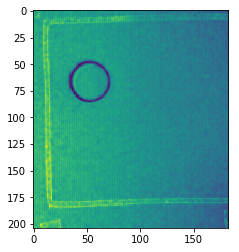

In [707]:
plt.imshow(depth_img)

In [708]:
# Remove zero pixels from depth images:
def clean_image(img):
    default_value = np.median(img)
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if img[i][j]==0:
                print 0,
                if img[i][j-1]:
                    img[i][j] = img[i][j-1]
                else:
                    img[i][j] = default_value
    return img

depth_img = clean_image(depth_img)
print "emp"
depth_emp_img = clean_image(depth_emp_img)
depth_emp_img2 = cv2.GaussianBlur(depth_emp_img,(3, 3), 0)
print "cal"
depth_cal_img = clean_image(depth_cal_img)

emp
cal
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


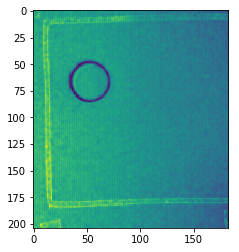

In [709]:
plt.imshow(depth_img)

897.53931

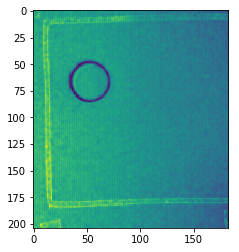

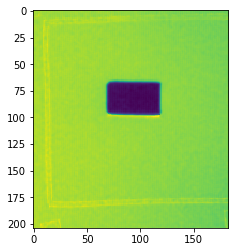

In [710]:
plt.imshow(depth_img)
plt.figure()
plt.imshow(depth_cal_img)
np.where(depth_img==depth_img.min())
depth_img.min()
depth_img[30][0]

In [711]:

clean_depth_img = depth_emp_img - depth_img
cal_depth_img = depth_emp_img - depth_cal_img

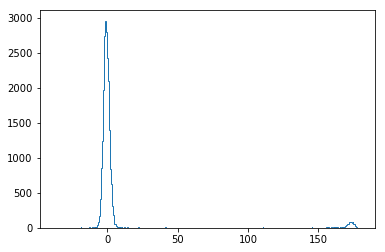

(-37.396484, 179.15875)

In [712]:

image_flat = cal_depth_img[np.isfinite(cal_depth_img)]

black,white = cal_depth_img.min(), cal_depth_img.max()

plt.figure()
counts, bins, bars = plt.hist(image_flat, bins = np.linspace(black,white,512), histtype='step')
plt.show()
cal_depth_img.min(), cal_depth_img.max()

[[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]]
4
(204, 183)
(2,)
[[[-1 -1  1 -1]
  [-1 -1 -1  0]]]


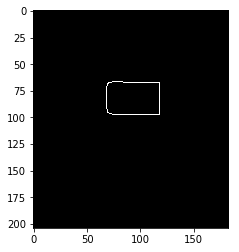

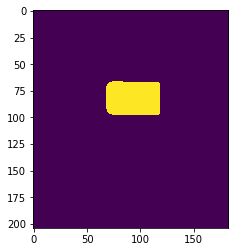

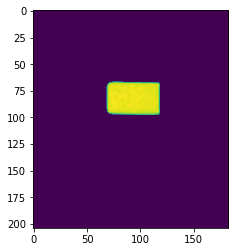

In [939]:
def extract_contours(image, min_thresh=10, max_thresh=50, dilate=1, erode=1):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = copy.copy(image)
    gray[gray<0] = 0
    gray=gray.astype('uint8')
    gray[gray==255]=0
    #gray = cv2.GaussianBlur(gray, (7, 7), 0)
    print gray
    print gray[0].max()
    gray_clr = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    #plt.imshow(gray_clr)
    #print gray_clr
    
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(gray, min_thresh, max_thresh)
    edged = cv2.dilate(edged, None, iterations=dilate)
    edged = cv2.erode(edged, None, iterations=erode)

    img, cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    print np.shape(img)
    #cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    return edged, cnts, hierarchy, img
cal_used_img = copy.copy(cal_depth_img)
edged, cal_cnts, hierarchy, img  = extract_cal_contours(cal_used_img, min_thresh=10, max_thresh=240)
plt.figure("hello")
edged_clr = cv2.cvtColor(edged, cv2.COLOR_GRAY2RGB)
plt.imshow(edged_clr)
print np.shape(cal_cnts)

def mean_in_contour(img, mask=None, show=True):
    image = copy.copy(img)
    if mask is None:
        mask = np.ones(image.shape, np.uint8)*255
    out = np.zeros_like(img)
    out[mask==255] = image[mask==255]
    
    if show==True:
        plt.figure()
        plt.imshow(mask)
        plt.figure()
        plt.imshow(out)
    
    #out_clr = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)

    contour_median = np.median(image[mask==255])
    contour_mean = np.mean(image[mask==255])
    contour_max = image[mask==255].max()
    contour_min = image[mask==255].min()
    return contour_median, contour_mean, contour_max, contour_min

#mask1 = np.zeros(superclean.shape, np.uint8)
#mask1 = cv2.drawContours(mask1, new_cnts[2], -1, (255), -1)
inner_contour_id = 0
for i,cnt in enumerate(cal_cnts):
    if hierarchy[0][i][2]==-1:
        inner_contour_id = i

mask = np.zeros(cal_depth_img.shape, np.uint8)
mask = cv2.drawContours(mask, [cal_cnts[1]], -1, (255), -1)
print hierarchy
plt.figure()
#plt.imshow(cal_depth_img)
plt.figure()
#plt.imshow(mask)
#for i in cal_cnts:
    #print cv2.contourArea(i)
    #box = cv2.minAreaRect(i)
    #box = cv2.boxPoints(box)
    #print box
len(mask[mask!=0])
max_median, max_mean, max_max, max_min = mean_in_contour(cal_depth_img, mask)

(-0.90673828, 5.9925828, 179.15875, -37.396484)

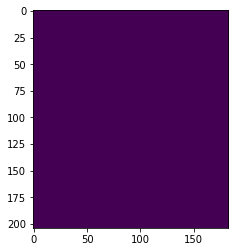

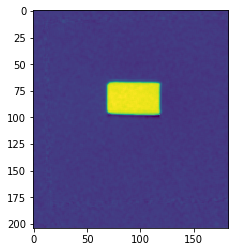

In [940]:
mean_in_contour(cal_depth_img)

In [932]:
import sys
def print_info(var_, full=True):    
    var_type = type(var_)
    print ("Type: ", var_type)
    if hasattr(var_, "__getitem__"):
        print ("Length: ", len(var_))
        try:
            var_shape = np.shape(var_)
            print ("Shape: ",np.shape(var_))
            if full==True:
                new_var=var_
                var_len = len(new_var)
                print "Full Shape of first elements: "
                print var_len, type(new_var)
                while var_len>0:
                    if hasattr(new_var, "__getitem__"):
                        new_var = new_var[0] 
                        try:
                            var_len = len(new_var)
                        except:
                            var_len=0                        
                    else:
                        print "break"
                        var_len = 0
                    print var_len,
                    print type(new_var)
                        
                    if type(new_var)==str:
                        var_len=0
        except:
            print ("Not an array")
            print sys.exc_info()[0]
    
                

In [933]:
print_info(hierarchy)

('Type: ', <type 'numpy.ndarray'>)
('Length: ', 1)
('Shape: ', (1, 2, 4))
Full Shape of first elements: 
1 <type 'numpy.ndarray'>
2 <type 'numpy.ndarray'>
4 <type 'numpy.ndarray'>
0 <type 'numpy.int32'>


In [934]:
hierarchy

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  0]]], dtype=int32)

In [750]:
img[97]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2, 130,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

(-9.6279907, 40.837219, 0.20144653)
[ 0  1  2 -1 -2 -3]
-0.101775 172.041


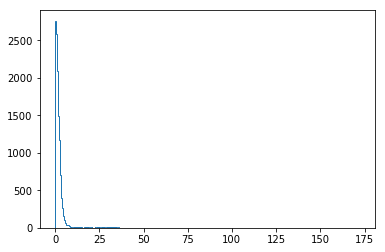

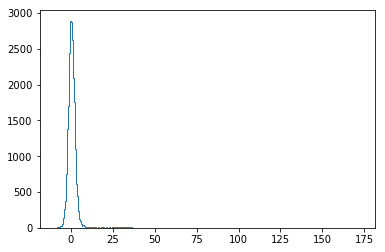

In [714]:
%matplotlib inline

range_max_height = max_median


print (clean_depth_img.min(), clean_depth_img.max(), np.median(clean_depth_img))

image_flat = clean_depth_img[np.isfinite(clean_depth_img)]

table_rows = np.array([i for i in range(3)])
table_rows = np.append(table_rows, -(table_rows+1))
print table_rows

black,white = min([np.mean(clean_depth_img[i]) for i in table_rows]), range_max_height
print black, white
#black,white = np.percentile(image_flat, 1), np.percentile(image_flat, 99)

plt.figure()
counts, bins, bars = plt.hist(image_flat, bins = np.linspace(black,white,512), histtype='step')
plt.show()
plt.figure()
counts, bins, bars = plt.hist(image_flat, bins = np.linspace(clean_depth_img.min(),white,512), histtype='step')
plt.show()

-9.62799 40.8372


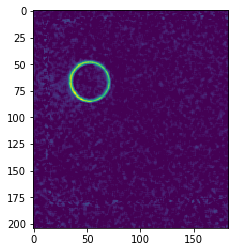

In [715]:
normclean = copy.copy(clean_depth_img)

print normclean.min(), normclean.max()

normclean[normclean>white] = range_max_height
normclean[normclean<black] = black

normclean = (normclean - black)/(white-black)
plt.imshow(normclean)

(204, 183)
(5,)
[[[-1 -1  1 -1]
  [ 2 -1 -1  0]
  [ 3  1 -1  0]
  [ 4  2 -1  0]
  [-1  3 -1  0]]]
('CONVEX?: ', False)
0
('CONVEX?: ', False)
3
[0, 3]
hello
[[[-1 -1 -1 -1]
  [-1 -1 -1  0]
  [ 3 -1 -1  0]
  [-1 -1 -1  0]
  [-1  3 -1  0]]]
new_h_started
[[[-1. -1. -1. -1.]
  [-1. -1. -1.  0.]]]
[[[-1. -1. -1. -1.]
  [-1. -1. -1.  0.]]]
[-1 -1 -1 -1]
[-1 -1 -1  0]
he 0
[[[-1 -1  1 -1]
  [-1 -1 -1  0]]]


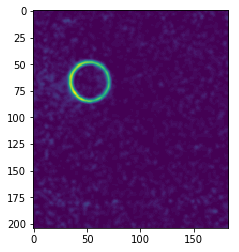

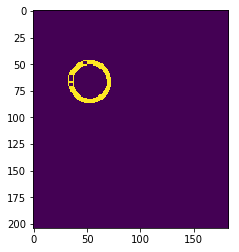

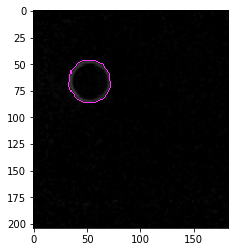

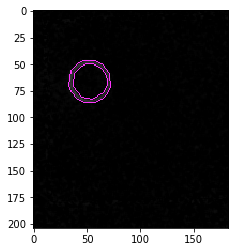

In [716]:
def extract_contours(image, min_thresh=120, max_thresh=180):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=(image*256).astype('uint8')
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.imshow(gray)
    
    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(gray, min_thresh, max_thresh)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    img, cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    print np.shape(img)
    #cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    return edged, cnts, hierarchy, img
edged, cnts, hierarchy, img  = extract_contours(normclean, min_thresh=10, max_thresh=40)
plt.figure()
plt.imshow(edged)
print np.shape(cnts)
print hierarchy
#print cnts[0]

new_cnts = []
new_hierarchy = []
h = copy.copy(hierarchy)
retain_list = []
minsize=80
used_img = copy.copy(normclean)
used_img = cv2.cvtColor(used_img, cv2.COLOR_GRAY2RGB)
for (i, c) in enumerate(cnts):
# if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < minsize:
        #print("Object #{} REJECTED because not big enough: ".format(i + 1), cv2.contourArea(c))
        continue
    
    print ("CONVEX?: ", cv2.isContourConvex(c))
    epsilon =  (0.01*cv2.arcLength(c,True))
    approx = cv2.approxPolyDP(c, epsilon, True)
    print i
    
    retain_list.append(i)
    
    box = approx
    #print(box)
    #box = cv2.boxPoints(box) #if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    new_cnts.append([box])
    
    cv2.drawContours(used_img, [box], -1, (5, 205, 5), 1)
    plt.figure()
    plt.imshow(used_img)

print retain_list
for i in range(np.shape(h)[1]):
    if i not in retain_list:
        h[h==i]=-1
print "hello"
print h
new_h = np.zeros((1, len(retain_list), 4))
for i,j in enumerate(retain_list):
    new_h[0][i] = h[0][j]
    
#for i in range(np.shape(h)[1]):
#    if h[0][i].all() == -1:
#        print i
#        h = np.delete(h,i,1)
print "new_h_started"
print new_h
for i,j in enumerate(retain_list):
    new_h[new_h==j]=i
print np.array(new_h)
new_h = new_h.astype('int8')
for j,k in enumerate(new_h[0]):
    print k
    if k[3]!=-1:
        print "he", k[3]
        if new_h[0][k[3]][2] == -1:
            new_h[0][k[3]][2] = j
        if k[3]==new_h[0][j-1][3]:
            print "keep consistent"
            new_h[0][j][1]=j-1
            new_h[0][j-1][0]=j
print np.array(new_h)

In [717]:
np.shape(normclean)
normclean.max()

0.23781981

[[-1 -1  1 -1]
 [-1 -1 -1  0]]
[1]
{'generation': 0, 'children': [1], 'id': 0}
{'generation': 1, 'children': [], 'id': 1}
1
0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0 1
('Current Child being drawn: ', 1)
('Parent Height: ', 0, (0.14197452, 0.13142416, 0.23781981, 0.0083025675))
('Child Height: ', 1, (0.009287715, 0.014051641, 0.12258394, 0.0))
child_to_pop []
{'generation': 0, 'children': [1], 'id': 0, 'height': (0.14197452, 0.13142416, 0.23781981, 0.0083025675)}
{'generation': -1, 'children': [], 'id': 1, 'height': (0.009287715, 0.014051641, 0.12258394, 0.0)}


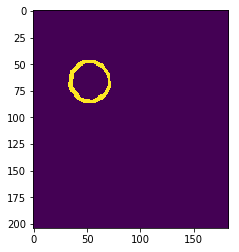

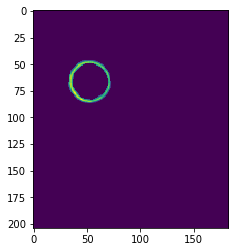

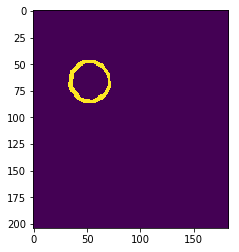

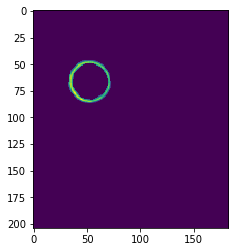

In [718]:
def sort_family(test_cnts, test_h):
    generation = [0 for i in range(len(test_h))]
    family = []

    for n,m in enumerate(test_h):
        heir = m
        cont = {}
        cont['id'] = n
        fellow_child = []
        if heir[2] != -1:
            first_child = test_h[heir[2]]
            fellow_child.append(heir[2])        
            while first_child[0] != -1:
                fellow_child.append(first_child[0])
                first_child = test_h[first_child[0]]
            print fellow_child

        if heir[3] != -1:
            generation[n] = generation[heir[3]] + 1

        cont['generation'] = generation[n]
        cont['children'] = fellow_child
        cont['contour'] = test_cnts[n]
        family.append(cont)

    return family
# Filter and organise family. 
test_h = copy.copy(new_h[0])
print test_h

family = sort_family(new_cnts,test_h)
#for member in family:
#    for key, value in member.items():
#        if key != 'contour':
#            print key, value
print_family = []
for member in family:
    new_member = copy.copy(member)
    del new_member['contour']
    print_family.append(new_member)
    print new_member
#print print_family 

max_gen = max([i['generation'] for i in family])
print max_gen
child_to_pop = []
for i in range(max_gen):
    child_to_pop = []
    for member_id, member in enumerate(family):
        if member['generation']==i:
            parent_mask = np.zeros(normclean.shape, np.uint8)
            parent_mask = cv2.drawContours(parent_mask, member['contour'], -1, (255), -1)
            children_mask = np.zeros(normclean.shape, np.uint8)
            child_mask = {}
            child_mean = {}
            print member['id'], "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
            for num, child in enumerate(member['children']):
                print num, child
                child_mask[num] = np.zeros(normclean.shape, np.uint8)
                child_mask[num] = cv2.drawContours(child_mask[num], family[child]['contour'], -1, (255), -1)
                child_mean[num] = mean_in_contour(normclean, child_mask[num], show=False)
                print('Current Child being drawn: ', child)
                children_mask = child_mask[num] + children_mask
            parent_child_separation = mean_in_contour(normclean, parent_mask-children_mask)
            print ("Parent Height: ",member_id, parent_child_separation)
            if parent_child_separation[1] < 0.04:
                    print (member_id, "Object is a bit short")
            #child_to_pop = []
            for num, child in enumerate(member['children']):
                print ("Child Height: ",child,child_mean[num])
                family[child]['height'] = child_mean[num]
                if abs(parent_child_separation[0]-child_mean[num][0]) < 0.04 :
                    #family[child]['generation']=i
                    print num, "@@@@@@@@@@@::::::::::::@@@@@@@@@@@@@@@@"
                    print "£££££", child
                    #print family[member_id]['children'].remove(child)
                    
                    removed_child_mask = cv2.drawContours(np.zeros(normclean.shape, np.uint8), 
                                                          family[child]['contour'], -1, (255), -1)
                    children_mask = children_mask - removed_child_mask
                    child_to_pop.append(child)
                    #family.pop(child)
                    #for new_id, new_member in enumerate(family):
                    #    if new_member['id']>child:
                    #        family[new_id]['id'] = new_member['id']-1
                    #    print new_member["children"]
                     ##   if len(new_member["children"])>0:
                     #       for n, new_child in enumerate(new_member["children"]):
                     #           if new_child>child:
                      #              family[new_id]['children'][n] = new_child-1
                    #print "new_children", family[member_id]['children']                    
                elif parent_child_separation[0]-child_mean[num][0] > 0.04:
                    family[child]['generation']=family[member_id]['generation']-1
                    #print child-num_removed, '@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'
                else:
                    family[child]['generation']=family[member_id]['generation']+1
                    #family[child-num_removed]['height'] = child_mean[num]
            
            parent_child_separation = mean_in_contour(normclean, parent_mask - children_mask)
            family[member_id]['height'] = parent_child_separation
            print "child_to_pop", child_to_pop
    for child_ in list(reversed(child_to_pop)):
        for member_ in family:
            if child_ in member_['children']:
                member_['children'].remove(child_)
        family.pop(child_)
    for new_id, new_member in enumerate(family):
        if new_member['id']!=new_id:
            print "test", new_member['id']
            for kkk in range((new_member['id'])):
                if new_member['id'] in family[kkk]['children']:
                    print kkk
                    family[kkk]['children'] = [new_id if mmm == new_member['id'] else new_member['id']
                                               for mmm in family[kkk]['children'] ]
            family[new_id]['id'] = new_id
                
                    #family[parent]['height'] = parent_child_separation
                #elif parent_child_separation[0]


print_family = []
for member in family:
    new_member = copy.copy(member)
    
    del new_member['contour']
    print_family.append(new_member)
    print new_member

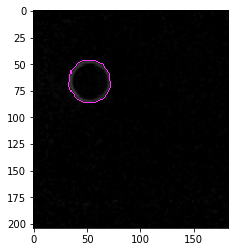

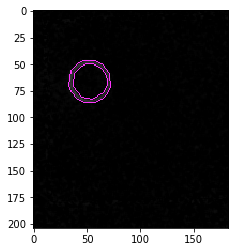

In [719]:
used_img = copy.copy(normclean)
used_img = cv2.cvtColor(used_img, cv2.COLOR_GRAY2RGB)
for member in family:
    cv2.drawContours(used_img, member['contour'], -1, (5, 205, 5), 1)
    plt.figure()
    plt.imshow(used_img)

In [720]:
family

[{'children': [1], 'contour': [array([[[47, 47]],
   
          [[42, 49]],
   
          [[35, 56]],
   
          [[33, 70]],
   
          [[35, 76]],
   
          [[41, 83]],
   
          [[48, 86]],
   
          [[57, 86]],
   
          [[64, 83]],
   
          [[69, 78]],
   
          [[72, 71]],
   
          [[71, 59]],
   
          [[64, 50]],
   
          [[57, 47]]])], 'generation': 0, 'height': (0.14197452,
   0.13142416,
   0.23781981,
   0.0083025675), 'id': 0},
 {'children': [], 'contour': [array([[[50, 50]],
   
          [[55, 50]],
   
          [[63, 54]],
   
          [[67, 59]],
   
          [[69, 65]],
   
          [[69, 70]],
   
          [[65, 77]],
   
          [[55, 83]],
   
          [[45, 81]],
   
          [[37, 71]],
   
          [[38, 59]],
   
          [[45, 52]]])], 'generation': -1, 'height': (0.009287715,
   0.014051641,
   0.12258394,
   0.0), 'id': 1}]

In [721]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

import object_detection_tools as odt
from suction_demo import import_constants, check_camera
from suction_demo import extract_contours, capture_pic, crop_table
from suction_demo import pix2world_cal, pix2world
from suction_demo import pix2world_find_circles_shelf, pix2world_shelf
#from object_grasping import ur_move, safe_ur_move, get_position, banana, fork
from utils import visualization_utils as vis_util

detection_graph, category_index=odt.initialise_nn()

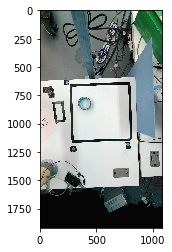

In [722]:
import time
FIND_OBJECT = ['fork', "wine glass", "banana", "sports ball", "bottle", "book",
"cell phone", "mouse", "bowl", "orange", "clock", "surfboard", 'spoon']#, 'airplane']

OBJECT_ID = [object_info['id'] for object_info
        in list(category_index.values())
        if (object_info['name'] in FIND_OBJECT)]

time.sleep(2)

emp_table_img_rgbx = im_array['rgb']['emp']
table_img_rgbx = im_array['rgb']['ori']
#cv2.imshow("Current Image", table_img)
plt.imshow(table_img_rgbx)

26
All Calibration points found
Quit
[[[ 146.5         611.5           6.51920223]
  [ 118.5         318.5           6.51920223]
  [ 385.5         590.5           6.51920223]]]
[[ 118.5         318.5           6.51920223]
 [ 385.5         590.5           6.51920223]
 [ 146.5         611.5           6.51920223]]
[[ 118.5         318.5           6.51920223]
 [ 146.5         611.5           6.51920223]
 [ 385.5         590.5           6.51920223]]
[[[ 118.5         318.5           6.51920223]
  [ 146.5         611.5           6.51920223]
  [ 385.5         590.5           6.51920223]]]


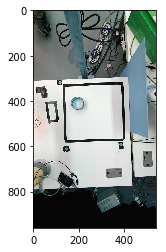

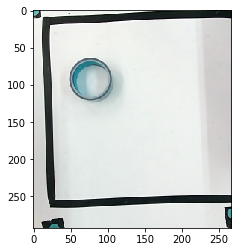

In [723]:
param = {'thresh': [45,100],
        'radius': [6, 9]}
show=True

r,g,b,x = cv2.split(emp_table_img_rgbx)
emp_table_img = cv2.merge([r,g,b])


r,g,b,x = cv2.split(table_img_rgbx)
table_img = cv2.merge([r,g,b])

table_img = cv2.resize(table_img, (0,0), fx=0.5, fy=0.5)
emp_table_img = cv2.resize(emp_table_img, (0,0), fx=0.5, fy=0.5)
#table_img = cv2.resize(table_img, (np.shape(depth_img)[1], np.shape(depth_img)[0]))
blurred_img = cv2.medianBlur(emp_table_img, 3)
blurred_img2 = copy.copy(blurred_img)[0:650, 0:400]
blurred_img2[0:300, 0:400] = 0
blurred_img2[0:650, 0:90] = 0
gimg = cv2.cvtColor(blurred_img2, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(blurred_img)
circles = None
counter = 0

while counter < 39 :
    #print (counter)
    circles = cv2.HoughCircles(gimg.astype("uint8"), cv2.HOUGH_GRADIENT, 1, 20,
                                   param1=param['thresh'][1],
                                   param2=param['thresh'][0]-counter,
                                   minRadius = param['radius'][0],
                                   maxRadius = param['radius'][1])

    if circles is not None and len(circles[0])>2:
        print param['thresh'][0]-counter
        print ('All Calibration points found')
        break

    counter = counter + 1

if circles is None:
    print ('No circles Detected, try changing param values')
cimg = cv2.cvtColor(gimg,cv2.COLOR_GRAY2BGR)
#cimg = copy.copy(ir_img)
for i in circles[0,:]:
        # draw the outer circle
    cv2.circle(cimg,(int(i[0]),int(i[1])),int(i[2]),(0,0,255),1)
        # draw the center of the ci~rcle
    cv2.circle(cimg,(int(i[0]),int(i[1])),2,(0,0,255),1)

if show==True:
    cv2.imshow("Calibration Points Identified", cimg)
    cv2.imwrite("calibrated_image.jpg", cimg)
    if cv2.waitKey():# & 0xFF == ord('q'):
        print ("Quit")
    cv2.destroyAllWindows()
print circles

circles_sorted = np.zeros(shape=np.shape(circles))
# Sort so that circle points ordered clockwise from top left
circles_sorted[0] = circles[0][np.argsort(circles[0][:,1])]
print (circles_sorted[0])
circles_sorted[0][1:] = circles_sorted[0][1:][np.argsort(circles_sorted[0][1:][:,0])]
#circles_sorted[0][2:] = circles_sorted[0][2:][np.argsort(circles_sorted[0][2:][:,1])]
print (circles_sorted[0])

crop_points = [circles_sorted[0][0][1], circles_sorted[0][1][1], 
               circles_sorted[0][0][0], circles_sorted[0][2][0]]
print (circles_sorted)
circles_sorted = circles_sorted.astype('uint16')
plt.imshow(table_img)
crop_points_table = [circles_sorted[0][0][1], circles_sorted[0][1][1], 
               circles_sorted[0][0][0], circles_sorted[0][2][0]]

crop_table_img = table_img[crop_points_table[0]:crop_points_table[1], crop_points_table[2]:crop_points_table[3]]
plt.figure()
plt.imshow(crop_table_img)

crop_table_img = cv2.resize(crop_table_img, (np.shape(depth_img)[1], np.shape(depth_img)[0]))

In [724]:
print classes

OBJECT_ID = [object_info['id'] for object_info
        in list(category_index.values())
        if (object_info['name'] in FIND_OBJECT)]

print [object_info['name'] for object_info in list(category_index.values()) if object_info['id'] in filtered_classes[0:2]]

[[ 52.  67.  67.  67.  52.  52.  67.  67.  52.  67.  52.  52.  52.  52.
   52.  52.  52.  52.  52.  49.  52.  52.  52.  52.  52.  67.  52.  62.
   52.  52.  52.  52.  52.  52.  52.   1.  52.  52.  52.  52.  52.  52.
    1.  52.  52.  52.  52.  52.  52.   1.  52.  50.  52.  52.  52.  52.
   49.  62.  62.  67.  52.  62.   1.  52.  52.  52.  62.  67.  48.   5.
   52.  52.  62.  52.  62.  62.  67.  52.  52.  52.   3.  70.  70.  52.
   52.  62.  10.  67.  52.  62.  52.   1.  67.  62.  49.  52.  62.  67.
   67.  52.]]
[u'banana']


Detecting objects in image 'kinect_rgb_crop.jpg'


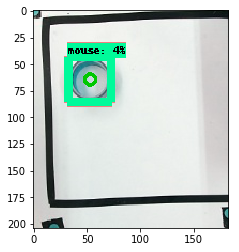

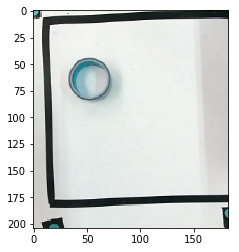

In [725]:
CROP_TABLE_IMG = "kinect_rgb_crop.jpg"

cv2.imwrite(CROP_TABLE_IMG, crop_table_img)

boxes, scores, classes, num_detections = odt.detection(
                                     CROP_TABLE_IMG, 
                                     detection_graph, 
                                     category_index
                                     )
NUM_OBJECT=2
filtered_boxes, filtered_classes, filtered_scores = odt.find_objects(
                                     OBJECT_ID, NUM_OBJECT, 
                                     boxes, scores, classes
                                     )
image, object_centres, pix_coords = odt.find_centres(
                                CROP_TABLE_IMG, 
                                filtered_boxes
                                )
image = odt.bound_class_boxes(
               image, 
               category_index, 
               filtered_boxes,
               filtered_classes,
               filtered_scores)
%matplotlib inline
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(crop_table_img)
#cv2.imshow("image",image)
#cv2.waitKey()

0
Quit


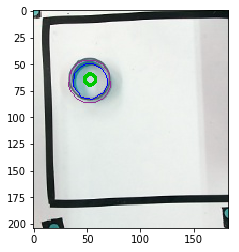

In [726]:
final_img = copy.copy(crop_table_img)
final_img, object_centres, pix_coords = odt.find_centres(
                                CROP_TABLE_IMG, 
                                filtered_boxes
                                )
#final_img = cv2.resize(final_img, (np.shape(depth_img)[1],np.shape(depth_img)[0]))

for member in family:
    if member['generation']==0:
        print member['id']
        cv2.drawContours(final_img, member['contour'], 0, (150,50,150), 1)
    
    if member['generation']==-1:
        cv2.drawContours(final_img, member['contour'], 0, (0,0,255), 1)
    if member['generation']==1:
        cv2.drawContours(final_img, member['contour'], 0, (200,50,100), 1)
#final_img = cv2.circle(copy.copy(final_img),(int(first_node[0]),int(first_node[1])),2,(255,255,0),3)
    
plt.imshow(final_img)
        
show_img = cv2.resize(final_img, (0,0), fx=3, fy=3)
if show==True:
    cv2.imshow("Calibration Points Identified", show_img)
    cv2.imwrite("calibrated_image.jpg", show_img)
    if cv2.waitKey():# & 0xFF == ord('q'):
        print ("Quit")
    cv2.destroyAllWindows()

green=0


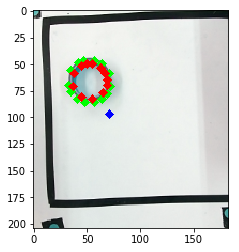

In [727]:
final_img2 = copy.copy(crop_table_img)
#final_img2, object_centres, pix_coords = odt.find_centres(
                                #CROP_TABLE_IMG, 
                                #filtered_boxes
                                #)
coord_count = 0
cv2.circle(final_img2,(int(cv2_current_centre[1]),int(cv2_current_centre[0])),2,(0,0,255),3)
for member in family:
    for coord in member['contour'][0]:
        #print coord
        
        cv2.circle(final_img2,(coord[0][0],coord[0][1]),2,(coord_count*250,255-255*coord_count,0),3)
    coord_count = coord_count +1
plt.imshow(final_img2)
print ("green=0")

In [728]:
def find_related_contours(test_family, box):
    accepted = []
    for member in test_family:
        cnt = member['contour'][0]
        inside = 0
        total = len(cnt)
        

        for point in cnt:

            if point[0][1]>box[0] and point[0][1]<box[2] and point[0][0]>box[1] and point[0][0]<box[3]:
                inside = inside+1

        print float(inside)/total
        if float(inside)/total > 0.3:
            accepted.append(member['id'])
    return accepted

print object_centres[0]

accepted = find_related_contours(family, pix_coords[0])

from scipy.spatial.distance import cdist

def closest_node(node, nodes):
    return nodes[cdist([node], nodes).argmin()]
print "Accepted", accepted

[65.0343918800354, 53.071765512228012]
0.642857142857
0.833333333333
Accepted [0, 1]


In [729]:
def pnt2line(pnt, start, end):
    line_vec = end-start
    pnt_vec = pnt-start
    line_len = np.sqrt(line_vec[0]**2+line_vec[1]**2)
    #print line_vec, line_len
    line_unitvec = (line_vec)/line_len
    pnt_vec_scaled = pnt_vec*1.0/line_len
    t = np.dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = line_vec*t
    dist = np.sqrt(sum((pnt_vec-nearest)**2))
    nearest = start + nearest
    return (dist, nearest)

In [730]:
def find_closest_contour(point, family):
    closest_contour=family[0]
    closest_contour['distance'] = cv2.pointPolygonTest((family[0]['contour'][0]), 
                                                   (point[0],point[1]), 
                                                   measureDist=True)
    print len(family)
    for i in range(len(family)):
        distance = cv2.pointPolygonTest((family[i]['contour'][0]), 
                                        (point[0],point[1]), 
                                        measureDist=True)
        print distance, closest_contour['distance']
        if abs(distance)<abs(closest_contour['distance']):
            closest_contour = family[i]
            closest_contour['distance']=distance
    return closest_contour

def find_point_generation(point, family):
    closest_contour = find_closest_contour(point, family)
    print "CONTOUR_ID: ", closest_contour['id']
    distance = cv2.pointPolygonTest(closest_cnt['contour'][0], 
                                    (point[0],point[1]), measureDist=True)
    if distance < 0:
        print "OUTSIDE NEAREST CONTOUR"
        child_count = 0
        for member in family:
            if closest_contour['id'] in member['children']:
                print "INSIDE PARENT"
                parent_dist = cv2.pointPolygonTest(member['contour'][0],
                                                  (point[0], point[1]), measureDist=True)
                if parent_dist<0:
                    print "SOMETHING WRONG HAS HAPPENED"
                else:
                    point_generation = member['generation']
                    child_count = child_count + 1
        if child_count == 0:
            point_generation = closest_contour['generation']-1
    else:
        point_generation = closest_contour['generation']
    
    return point_generation


In [731]:
find_point_generation([ 54.27797827,  83.56406032], family)


2
2.43593597412 2.43593597412
-0.694710645881 2.43593597412
CONTOUR_ID:  1
OUTSIDE NEAREST CONTOUR
INSIDE PARENT


0

In [732]:
current_centre = object_centres[0]
cv2_current_centre = list(reversed(current_centre))

In [733]:
distance = cv2.pointPolygonTest((family[1]['contour'][0]), (object_centres[0][1], object_centres[0][0]), measureDist=True)
print "Object Centre to Contour ", 0, " Distance: ", distance

Object Centre to Contour  0  Distance:  14.3095026821


In [734]:
closest_cnt = family[0]
closest_cnt['distance'] = cv2.pointPolygonTest((family[0]['contour'][0]), 
                                               (cv2_current_centre[0],cv2_current_centre[1]), 
                                               measureDist=True)
#centre_generation = closest_cnt['generation'] + int(distance/abs(distance))

for i in accepted:
    distance = cv2.pointPolygonTest((family[i]['contour'][0]), (object_centres[0][1], object_centres[0][0]), measureDist=True)
    print "Object Centre to Contour ", i, " Distance: ", distance
    if abs(distance)<abs(closest_cnt['distance']):
        closest_cnt = family[i]
        closest_cnt['distance'] = distance
        #centre_generation = closest_cnt['generation'] + int(distance/abs(distance))

#dist_ref = 200
#nearest_point = [0,0]
#for i in possible_pairs:
#    dist, nearest = pnt2line(first_node, i[0], i[1])
 #   if dist_ref>dist:
 #       dist_ref = dist
 ##       print dist
 #       second_node = [int(p) for p in nearest]#
#print second_node
        
current_cnt = []
for points in closest_cnt['contour'][0]:
    current_cnt.append(points[0])
first_node1 = closest_node(cv2_current_centre, current_cnt)

for qq, pp in enumerate(closest_cnt['contour'][0]):
    #print pp[0]
    if np.all(pp[0]==first_node1):
        if pp[0][0]==first_node1[0] and pp[0][1]==first_node1[1]:
            first_node1_location =qq

first_neighbours=closest_cnt['contour'][0][first_node1_location-1:first_node1_location+2:2]
#print [abs(g[0][0]**2 + g[0][1]**2) for g in first_neighbours]
print first_neighbours, first_node1
first_node2 = first_neighbours[np.argmin([abs((g[0][0]-cv2_current_centre[0])**2 
                                                  + (g[0][1]-cv2_current_centre[1])**2) for g in first_neighbours])]
first_node2 = first_node2[0]

print "First Node1: ", first_node1
print "First Node2: ", first_node2
dist, first_node = pnt2line(cv2_current_centre, first_node1, first_node2)
print dist, first_node

#Find first node:
current_cnt = []
#for points in closest_cnt['contour'][0]:
#    current_cnt.append(points[0])
#first_node = closest_node(cv2_current_centre, current_cnt)
print "Object Centre: ", cv2_current_centre
print "First Node: ", first_node


#current_line = 
#print "current", current_line

vect = first_node2-first_node1
print "Vector: ", vect
gradient = float(vect[1])/vect[0]
print gradient
if gradient == 0:
    current_line = [0.0, 1.0]
else:
    perp_grad = -1/gradient
    current_line = [1.0, perp_grad]

print "Perpendicular Line",current_line
#current_line = second_node-first_node
possible_pairs = []
for x in accepted:
    sec_cnt = []
    for points in family[x]['contour'][0]:
        sec_cnt.append(points[0])
    #print sec_cnt
    for i,j in enumerate(sec_cnt):
        #print j
        if i>0:
            check1 = sec_cnt[i-1] - first_node
            check2 = sec_cnt[i] - first_node
            sign1 = check1[0]*current_line[1] - check1[1]*current_line[0]
            sign2 = check2[0]*current_line[1] - check2[1]*current_line[0]
            #print sign1, sign2
            #print (sign1/abs(sign1), sign2/abs(sign2))
            
            if sign1*sign2 <0:
                possible_pairs.append([sec_cnt[i-1], sec_cnt[i]])
                
#print "Possible Pairs: ",possible_pairs
#print "Length: ", len(possible_pairs)

for pair_num,pair in enumerate(list(reversed(possible_pairs))):
    #print "Checking current pair: ", pair_num, pair
    #print "Against: ", first_node1, " and ", first_node2
    if np.array_equal(first_node1, pair[0]) or np.array_equal(first_node1, pair[1]):
        if np.array_equal(first_node2, pair[0]) or np.array_equal(first_node2, pair[1]):
            #print possible_pairs
            print pair
            possible_pairs.pop(-(pair_num+1))
                
print "possible second_pair: ", possible_pairs  
print len(possible_pairs)

possible_second_node=[]
for i in possible_pairs:
    dist, nearest = pnt2line(first_node, i[0], i[1])
    possible_second_node.append([p for p in nearest])
#print "Possible Second Nodes: ", possible_second_node
#print  "Length possible second nodes: ", len(possible_second_node)
actual_grasp_centre = []

remove_snode = []
for num_snode, snode in enumerate(possible_second_node):
    node_separation = snode - first_node
    grasp_centre = first_node + node_separation/2
    print "...............................", snode
    print "GRASP CENTRE: ",grasp_centre
            
    grasp_node1 = first_node - node_separation*0.02
    grasp_node2 = snode + node_separation * 0.02
    grasp_gen = {}
    for gnum, grasp_point in enumerate([grasp_node1, grasp_centre, grasp_node2]):
        grasp_gen[gnum]=find_point_generation(grasp_point, family)
        print gnum, "+++++++++++++++",grasp_gen
        print grasp_point
    print "Grasp generations: ", grasp_gen
    print ""
    if grasp_gen[0]!=grasp_gen[2]:
        remove_snode.append(num_snode)
        print "::::: Grasping points at different levels"
    elif grasp_gen[1]<grasp_gen[0]:
        remove_snode.append(num_snode)
        print "::::; Grasping points are around hollow"
    else:
        print "::::: PERFECT"
        p
        actual_grasp_centre.append(grasp_centre)
    print ''

for i in list(reversed(remove_snode)):
    possible_second_node.pop(i)

print actual_grasp_centre
grasping_limit = 200
second_node = possible_second_node[0]


for snode in possible_second_node:
    node_dist = np.sqrt(sum((snode-first_node)**2))
    if node_dist < grasping_limit:
        grasping_limit = node_dist
        second_node = snode
        actual_grasp_centre = (snode+first_node)/2
        
print "Final Second Node: ", second_node
print "Actual Grasp Centre: ", actual_grasp_centre





Object Centre to Contour  0  Distance:  17.856450472
Object Centre to Contour  1  Distance:  14.3095026821
[[[55 50]]

 [[67 59]]] [63 54]
First Node1:  [63 54]
First Node2:  [55 50]
14.3095015759 [ 59.47116916  52.23558458]
Object Centre:  [53.071765512228012, 65.0343918800354]
First Node:  [ 59.47116916  52.23558458]
Vector:  [-8 -4]
0.5
Perpendicular Line [1.0, -2.0]
[array([55, 50]), array([63, 54])]
possible second_pair:  [[array([41, 83]), array([48, 86])], [array([64, 50]), array([57, 47])], [array([55, 83]), array([45, 81])]]
3
............................... [45.466113191843029, 84.914048510789868]
GRASP CENTRE:  [ 52.46864118  68.57481655]
2
3.1277587613 3.1277587613
-0.709834552321 3.1277587613
CONTOUR_ID:  1
OUTSIDE NEAREST CONTOUR
INSIDE PARENT
0 +++++++++++++++ {0: 0}
[ 59.75127028  51.5820153 ]
2
17.4251861572 17.4251861572
13.5939797933 17.4251861572
CONTOUR_ID:  1
1 +++++++++++++++ {0: 0, 1: -1}
[ 52.46864118  68.57481655]
2
-0.711063523905 -0.711063523905
-4.442439235

second_accepted=[]
for i in accepted:
    distance = cv2.pointPolygonTest((family[i]['contour'][0]), (first_node[0],first_node[1]), measureDist=True)
    print "Contour: ", i, ", Distance: ", distance
    if distance >= 0-(10**-4):
        print "Object centre is inside ", i
        if family[i]['generation']==closest_cnt['generation']:
            second_accepted.append(i)
    else:
        print "Object centre is outside ", i
        if family[i]['generation']==closest_cnt['generation']-1:
            second_accepted.append(i)
print "Second Accepted: ", second_accepted




Quit


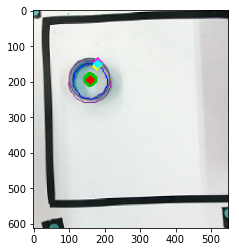

In [735]:
another_img = cv2.circle(copy.copy(final_img),(int(first_node[0]),int(first_node[1])),2,(255,255,0),3)
another_img = cv2.circle(copy.copy(another_img),
                         (int(cv2_current_centre[0]),int(cv2_current_centre[1])),2,(255,0,0),3)
#another_img = cv2.circle(copy.copy(another_img),(int(first_neighbours[0][0][0]),int(first_neighbours[0][0][1])),2,(255,255,0),3)
#for i in possible_pairs:

    #another_img = cv2.circle(copy.copy(another_img),(i[0][0],i[0][1]),2,(0,255,0),3)
    #another_img = cv2.circle(copy.copy(another_img),(i[1][0],i[1][1]),2,(0,255,0),3)
another_img = cv2.circle(copy.copy(another_img),(int(second_node[0]),int(second_node[1])),2,(255,0,255),3)
another_img = cv2.circle(copy.copy(another_img),(int(actual_grasp_centre[0]),int(actual_grasp_centre[1])),2,(0,255,255),3)
show_img = cv2.resize(another_img, (0,0), fx=3, fy=3)
if show==True:
    cv2.imshow("Calibration Points Identified", show_img)
    #cv2.imwrite("calibrated_image.jpg", show_img)
    if cv2.waitKey():# & 0xFF == ord('q'):
        print ("Quit")
    cv2.destroyAllWindows()
plt.imshow(show_img)

In [736]:
family[0]['contour'][0][0][0]

array([47, 47])

In [737]:
np.shape(another_img)

(204, 183, 3)

In [738]:
circles_sorted_depth-circles_sorted_depth[0][0]

array([[[   0.,    0.,    0.],
        [  17.,  204.,    0.],
        [ 183.,  191.,    0.]]])

In [739]:
first_node, second_node

(array([ 59.47116916,  52.23558458]), [60.983354571153377, 48.707151959065733])

In [740]:
np.shape(depth_img)

(204, 183)